## 1. Same (almost) as in the lecture notebook, except that phrase pairs are rus-eng and taken from https://www.manythings.org

In [1]:
#%matplotlib inline

In [1]:
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# !wget https://download.pytorch.org/tutorial/data.zip
!wget https://www.manythings.org/anki/rus-eng.zip
!unzip rus-eng.zip

--2024-10-22 23:05:59--  https://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16305013 (16M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  15,55M   205KB/s    in 98s     

2024-10-22 23:07:39 (162 KB/s) - ‘rus-eng.zip’ saved [16305013/16305013]

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


In [3]:
!tail rus.txt

We need to uphold laws against discrimination — in hiring, and in housing, and in education, and in the criminal justice system. That is what our Constitution and our highest ideals require.	Нам нужно отстаивать законы против дискриминации при найме на работу, в жилищной сфере, в сфере образования и правоохранительной системе. Этого требуют наша Конституция и высшие идеалы.	CC-BY 2.0 (France) Attribution: tatoeba.org #5762728 (BHO) & #6390439 (odexed)
I've heard that you should never date anyone who is less than half your age plus seven. Tom is now 30 years old and Mary is 17. How many years will Tom need to wait until he can start dating Mary?	Я слышал, что никогда не следует встречаться с кем-то вдвое младше вас плюс семь лет. Тому 30 лет, a Мэри 17. Сколько лет Тому нужно ждать до тех пор, пока он сможет начать встречаться с Мэри?	CC-BY 2.0 (France) Attribution: tatoeba.org #10068197 (CK) & #10644473 (notenoughsun)
I do have one final ask of you as your president, the same thing I a

In [4]:
!head rus.txt

Go.	Марш!	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)
Go.	Иди.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898247 (marafon)
Go.	Идите.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898250 (marafon)
Hi.	Здравствуйте.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #402127 (odexed)
Hi.	Привет!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #466968 (katjka)
Hi.	Хай.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #467233 (timsa)
Hi.	Здрасте.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #3803577 (marafon)
Hi.	Здоро́во!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #3854188 (marafon)
Hi.	Приветик!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #7234283 (marafon)
Run!	Беги!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1569978 (Biga)


### All phrase pairs appear to have a piece of seemingly irrelevant text attached to the end of the type "CC-BY 2.0...(...)". Let's define  a function to get rid of it:

In [5]:
def clearString(s):
    s = re.sub("\tCC-BY 2\.0.*\)$", "", s)
    return s

In [6]:
st = "Run!\tБеги\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1569978 (Biga)"
print(clearString(st))
# print(st)

Run!	Беги


In [7]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [8]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
#     s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"[^a-zA-Zа-яА-Я.!?]+", r" ", s)
    return s

In [9]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
#     lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
    lines = open('%s.txt' % ((lang1, lang2)[reverse]), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in clearString(l).split('\t')] for l in lines]
#     pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [10]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
#     "she is", "she s",
    "she is", "she s " , ##ADDED WHITESPACE AT THE END
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


# def filterPair(p):
def filterPair(p, eng = 0):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[eng-1].startswith(eng_prefixes) if eng else 1
#         p[1].startswith(eng_prefixes)


# def filterPairs(pairs):
#     return [pair for pair in pairs if filterPair(pair)]
def filterPairs(pairs, eng = 0):
    return [pair for pair in pairs if filterPair(pair, eng)]

In [11]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    print(pairs[0])
    eng = (not 'eng' in (lang1, lang2) or abs((lang1, lang2).index('eng') - reverse) + 2) - 1
    print(eng)
#   ### eng = 0 IF NEITHER IS ENGLISH, 1 IF INPUT IS ENGLISH, 2 OUTPUT IS ENGLISH OR VICE VERSA IF reverse IS TRUE
#     pairs = filterPairs(pairs)
    pairs = filterPairs(pairs, eng)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


# input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
input_lang, output_lang, pairs = prepareData('eng', 'rus', True)
print(random.choice(pairs))

Reading lines...
Read 496059 sentence pairs
['марш !', 'go .']
2
Trimmed to 28325 sentence pairs
Counting words...
Counted words:
rus 9894
eng 4169
['ты переиначиваешь мои слова .', 'you re twisting my words .']


The Encoder
-----------





In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder
-----------




In [13]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [15]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [16]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [17]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [18]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    base = 0.2 if max(points) - min(points) <= 3 else np.ceil(int(max(points) - min(points))/10)
#     loc = ticker.MultipleLocator(base=0.2)
    loc = ticker.MultipleLocator(base=base)
    ax.yaxis.set_major_locator(loc)
    plt.title("Loss vs iterations")
    plt.plot(points)

In [19]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [20]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

3m 23s (- 47m 34s) (5000 6%) 3.0631
6m 37s (- 43m 1s) (10000 13%) 2.5441
10m 1s (- 40m 4s) (15000 20%) 2.2883
13m 24s (- 36m 53s) (20000 26%) 2.0885
16m 41s (- 33m 23s) (25000 33%) 1.9155
20m 0s (- 30m 1s) (30000 40%) 1.7845
23m 18s (- 26m 38s) (35000 46%) 1.7149
26m 40s (- 23m 20s) (40000 53%) 1.5902
30m 5s (- 20m 3s) (45000 60%) 1.5288
33m 29s (- 16m 44s) (50000 66%) 1.4768
36m 52s (- 13m 24s) (55000 73%) 1.3862
40m 19s (- 10m 4s) (60000 80%) 1.3224
43m 43s (- 6m 43s) (65000 86%) 1.3102
47m 6s (- 3m 21s) (70000 93%) 1.2357
50m 33s (- 0m 0s) (75000 100%) 1.1621


<Figure size 640x480 with 0 Axes>

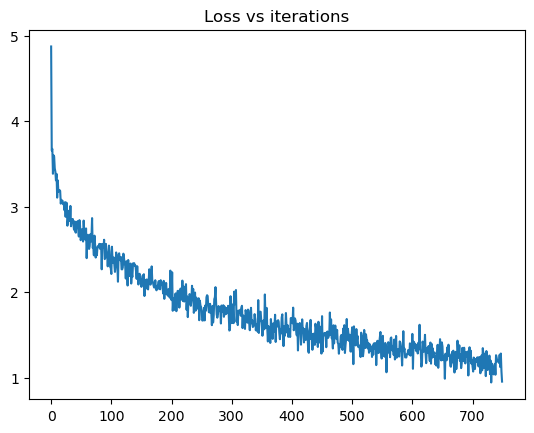

In [22]:
%matplotlib inline
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [23]:
evaluateRandomly(encoder1, attn_decoder1)

> я незастрахован .
= i m uninsured .
< i m shocked . <EOS>

> он на вас сердится .
= he is angry with you .
< he s all at you . <EOS>

> они боятся смерти .
= they are afraid of death .
< they re afraid to death . <EOS>

> тебя никогда нет дома .
= you re never at home .
< you re never at home . <EOS>

> боюсь у нас нет выбора .
= i m afraid that we have no choice .
< i m afraid we have no be . . <EOS>

> я устал от переводов .
= i m tired of translating .
< i m tired of your lies . <EOS>

> я пытаюсь помочь .
= i m trying to help .
< i m trying to help . <EOS>

> вы наверняка очень заняты .
= i m sure you re very busy .
< you re very busy busy . <EOS>

> я сеичас уроки делаю .
= i m doing my homework now .
< i m doing right now . <EOS>

> я слабыи .
= i m weak .
< i m weak . <EOS>



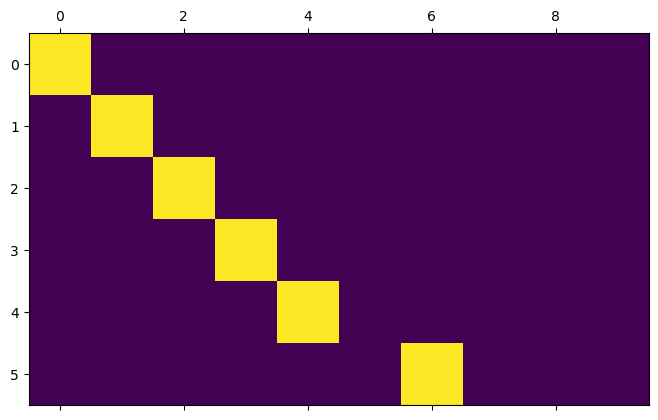

In [25]:
%matplotlib inline
output_words, attentions = evaluate(
#     encoder1, attn_decoder1, "je suis trop froid .")
    encoder1, attn_decoder1, "мне слишком холодно .")
plt.matshow(attentions.numpy())
plt.show()

input = она на пять лет младше меня .
output = she s five years younger than me . <EOS>


/tmp/ipykernel_235993/3085610971.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_235993/3085610971.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


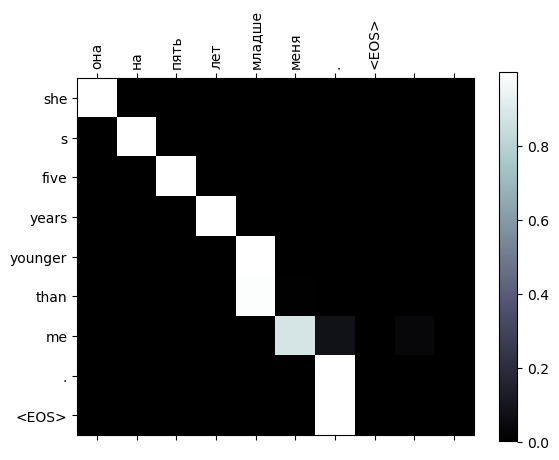

input = она слишком маленькая .
output = she s too young . <EOS>


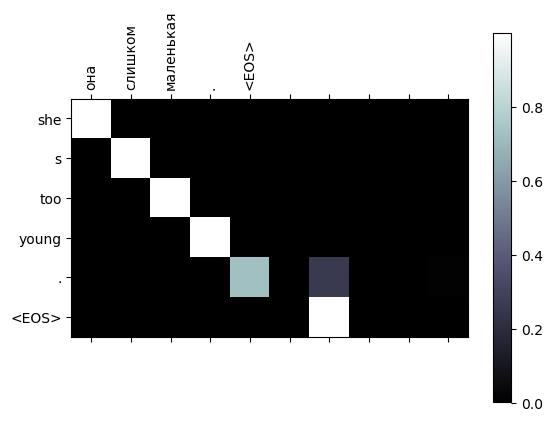

input = я не боюсь умереть .
output = i m not afraid to die . <EOS>


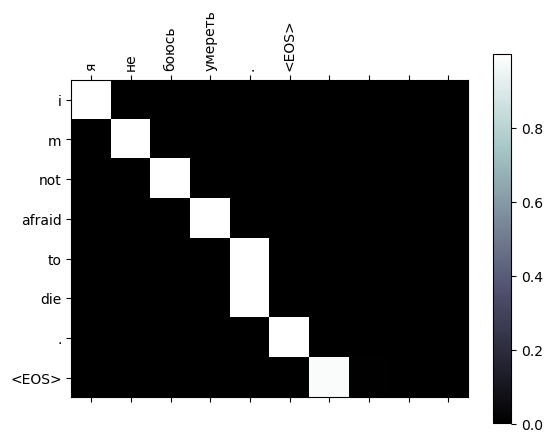

input = это молодои талантливыи режиссер .
output = he s probably at it to . . <EOS>


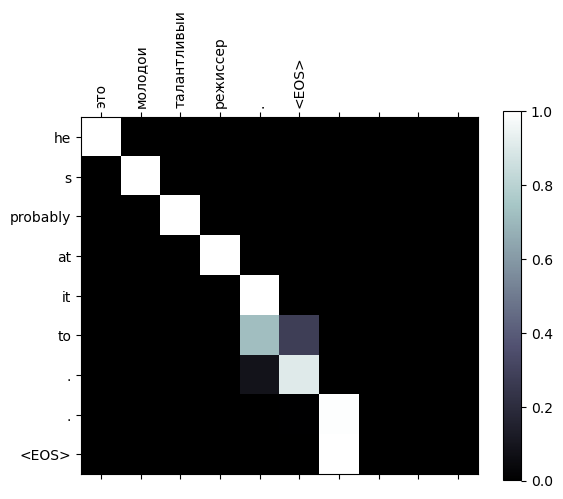

In [27]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


# evaluateAndShowAttention("elle a cinq ans de moins que moi .")
evaluateAndShowAttention("она на пять лет младше меня .")

# evaluateAndShowAttention("elle est trop petit .")
evaluateAndShowAttention("она слишком маленькая .")

# evaluateAndShowAttention("je ne crains pas de mourir .")
evaluateAndShowAttention("я не боюсь умереть .")

# evaluateAndShowAttention("c est un jeune directeur plein de talent .")
evaluateAndShowAttention("это молодои талантливыи режиссер .")

## 2. Attention scores via dot product

### We're going to need a modified decoder class. In it, we'll define a method to calculate attention weights via scaled dot product between decoder hidden state and encoder outputs

### The code for the function, although short, may seem a little messy: we first need to unsqueeze() encoder outputs to produce batch dimension, which is required by torch.bmm() function, then we squeeze() back the resulting matrix (using ...[0]), which will be unsqueezed again later in the code. This is only to avoid modifying the rest of the decoder class.

In [53]:
class AttnDecoderRNNDot(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNNDot, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def scores_via_dot_product(self, hidden, encoder_outputs): ##CHANGE HERE
        return torch.bmm(hidden, encoder_outputs.unsqueeze(0).permute(0,2,1))[0]/math.sqrt(hidden.shape[-1])

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

#         attn_weights = F.softmax(
#             self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_weights = F.softmax(
            self.scores_via_dot_product(hidden,encoder_outputs), dim=1)  ##CHANGE HERE
        
        
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

3m 6s (- 43m 37s) (5000 6%) 3.0564
6m 14s (- 40m 37s) (10000 13%) 2.5777
9m 28s (- 37m 54s) (15000 20%) 2.2962
12m 46s (- 35m 7s) (20000 26%) 2.0862
16m 9s (- 32m 19s) (25000 33%) 1.9354
19m 26s (- 29m 9s) (30000 40%) 1.7738
22m 51s (- 26m 6s) (35000 46%) 1.6814
26m 14s (- 22m 57s) (40000 53%) 1.6042
29m 35s (- 19m 43s) (45000 60%) 1.4809
32m 59s (- 16m 29s) (50000 66%) 1.3891
36m 22s (- 13m 13s) (55000 73%) 1.3544
39m 48s (- 9m 57s) (60000 80%) 1.2815
43m 15s (- 6m 39s) (65000 86%) 1.2390
46m 46s (- 3m 20s) (70000 93%) 1.1693
50m 5s (- 0m 0s) (75000 100%) 1.1340


<Figure size 640x480 with 0 Axes>

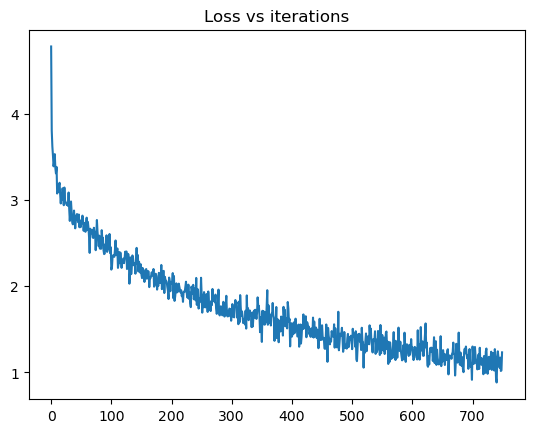

In [54]:
%matplotlib inline
hidden_size = 256
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNNDot(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder2, attn_decoder2, 75000, print_every=5000)

In [55]:
evaluateRandomly(encoder2, attn_decoder2)

> я рад что ты была права .
= i m glad you were right .
< i m glad you were right . <EOS>

> я стеснительныи мальчик .
= i am a shy boy .
< i m a boy boy . <EOS>

> мы едем в бостон .
= we re going to boston .
< we re going to boston . <EOS>

> я привык к запаху .
= i m used to the smell .
< i m used to that . <EOS>

> они идут .
= they are going .
< they re walking . <EOS>

> я романтик .
= i m a romantic .
< i m a . . <EOS>

> я очень застенчивыи .
= i m very shy .
< i m very shy . <EOS>

> нам понадобится заем .
= we re going to need a loan .
< we re going to be late . <EOS>

> вы слишком скромная .
= you re too humble .
< you re too humble . <EOS>

> вы хорошии друг .
= you re a good friend .
< you re a good friend . <EOS>



## 3. Attention scores via MLP

### The decoder in the lecure notebook used a single linear layer to compute attention scores. Let's expand on this and see if adding a second linear layer can make any difference

In [47]:
class AttnDecoderRNNMLP(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNNMLP, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        
#         self.attn = nn.Linear(self.hidden_size * 2, self.max_length)   ##CHANGE HERE
        self.attn_multi = nn.Sequential(
            nn.Linear(self.hidden_size * 2, self.hidden_size * 2),
            nn.ReLU(),
            nn.Dropout(self.dropout_p),
            nn.Linear(self.hidden_size * 2, self.max_length),
        )
        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
#             self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
            self.attn_multi(torch.cat((embedded[0], hidden[0]), 1)), dim=1) ##CHANGE HERE
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

3m 46s (- 52m 57s) (5000 6%) 3.0652
7m 33s (- 49m 9s) (10000 13%) 2.5586
11m 20s (- 45m 23s) (15000 20%) 2.2914
15m 5s (- 41m 30s) (20000 26%) 2.0697
18m 45s (- 37m 31s) (25000 33%) 1.9209
22m 31s (- 33m 46s) (30000 40%) 1.8084
26m 13s (- 29m 58s) (35000 46%) 1.7000
30m 2s (- 26m 17s) (40000 53%) 1.5975
33m 47s (- 22m 31s) (45000 60%) 1.5237
37m 39s (- 18m 49s) (50000 66%) 1.4781
41m 25s (- 15m 3s) (55000 73%) 1.3943
45m 17s (- 11m 19s) (60000 80%) 1.3217
49m 9s (- 7m 33s) (65000 86%) 1.2702
52m 50s (- 3m 46s) (70000 93%) 1.2449
56m 32s (- 0m 0s) (75000 100%) 1.2035


<Figure size 640x480 with 0 Axes>

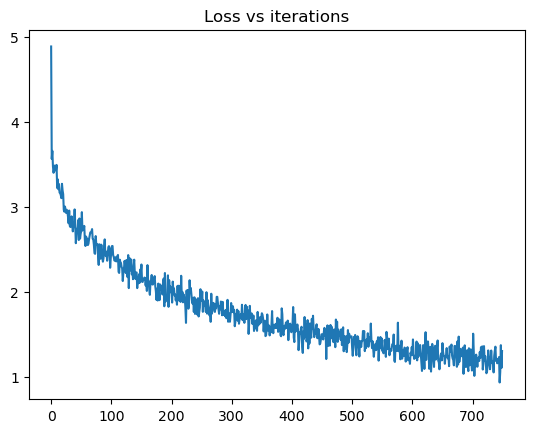

In [48]:
%matplotlib inline
hidden_size = 256
encoder3 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder3 = AttnDecoderRNNMLP(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder3, attn_decoder3, 75000, print_every=5000)

In [49]:
evaluateRandomly(encoder3, attn_decoder3)

> мы не боимся смерти .
= we re not afraid of death .
< we re not afraid of anyone . <EOS>

> ты вмешиваешься .
= you re interfering .
< you re a . <EOS>

> я уверен что могу наити его .
= i m sure i can find it .
< i m sure i can find it . <EOS>

> у меня кончился сахар .
= i m out of sugar .
< i m having out of <EOS>

> мы почти доехали .
= we are almost there .
< we re almost there . <EOS>

> я примерно такого же роста что и том .
= i m about the same height as tom .
< i m about the same age as tom . <EOS>

> теперь мы выбиваемся из графика .
= we re behind schedule now .
< we re making a of of <EOS>

> мы с тобои примерно ровесники .
= i m roughly the same age as you .
< i m about your age . <EOS>

> он очень хочет преуспеть .
= he is eager for success .
< he is very very to . . <EOS>

> я оставлю его себе .
= i m going to keep it .
< i m related to keep it . <EOS>



## Conclusion: all three decoders show roughly equal loss drop, time to train and quality of  translation